In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Set notebook preferences
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('Solarize_Light2')

In [3]:
import yaml
path= r'/Users/ksharma/Documents/ML Engineer/Machine Learning/Projects/paysim_credit_fraud_analysis/'
config_name= 'config.yaml'

#read yaml file
with open(os.path.join(path, config_name)) as file:
    config = yaml.safe_load(file)
    
df= pd.read_csv(config['paths']['cleanedData'], dtype={'isFraud':'object', 'isFlaggedFraud':'category'})
df.drop('Unnamed: 0', axis= 1, inplace= True)

**Data Overview**

In [4]:
#Preview data
display(df.shape)
display(df.head())

(6362620, 9)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,0,0
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,0,0
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,1,0
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            object  
 2   amount          float64 
 3   oldbalanceOrg   float64 
 4   newbalanceOrig  float64 
 5   oldbalanceDest  float64 
 6   newbalanceDest  float64 
 7   isFraud         object  
 8   isFlaggedFraud  category
dtypes: category(1), float64(5), int64(1), object(2)
memory usage: 394.4+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000
mean,243.397,179861.904,833883.104,855113.669,1100701.667,1224996.398
std,142.332,603858.231,2888242.673,2924048.503,3399180.113,3674128.942
min,1.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13389.570,0.000,0.000,0.000,0.000
50%,239.000,74871.940,14208.000,0.000,132705.665,214661.440
75%,335.000,208721.478,107315.175,144258.410,943036.708,1111909.250
max,743.000,92445516.640,59585040.370,49585040.370,356015889.350,356179278.920


In [7]:
#Missing data counts
df.isna().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### EDA

Fraud Distribution

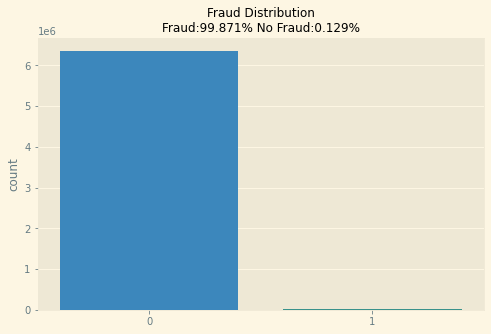

In [8]:
f, ax= plt.subplots(figsize= (8,5))

j= sns.countplot(x=df['isFraud'], ax= ax)

percentFraud= round((len(df.loc[df['isFraud'] =='1', :])/len(df)) * 100,3)
percentLegit= round((len(df.loc[df['isFraud'] =='0', :])/len(df)) * 100,3)

ax.set_title('Fraud Distribution\nFraud:%s No Fraud:%s' % (str(percentLegit)+'%', str(percentFraud)+'%'), fontsize= 12)
ax.set_xlabel('');

Correlation Matrix

In [9]:
#Copy original df & drop flags cols
temp= df.copy().drop('isFlaggedFraud', axis=1)

#Create dummies
dummies= pd.get_dummies(temp.iloc[:, :-1], drop_first=False)
dummies.loc[:,'isFraud']= temp.loc[:,'isFraud'].apply(lambda x: int(x))

dummies.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,1,9839.640,170136.000,160296.360,0.000,0.000,0,0,0,1,0,0
1,1,1864.280,21249.000,19384.720,0.000,0.000,0,0,0,1,0,0
2,1,181.000,181.000,0.000,0.000,0.000,0,0,0,0,1,1
3,1,181.000,181.000,0.000,21182.000,0.000,0,1,0,0,0,1
4,1,11668.140,41554.000,29885.860,0.000,0.000,0,0,0,1,0,0


Successfully saved image to path


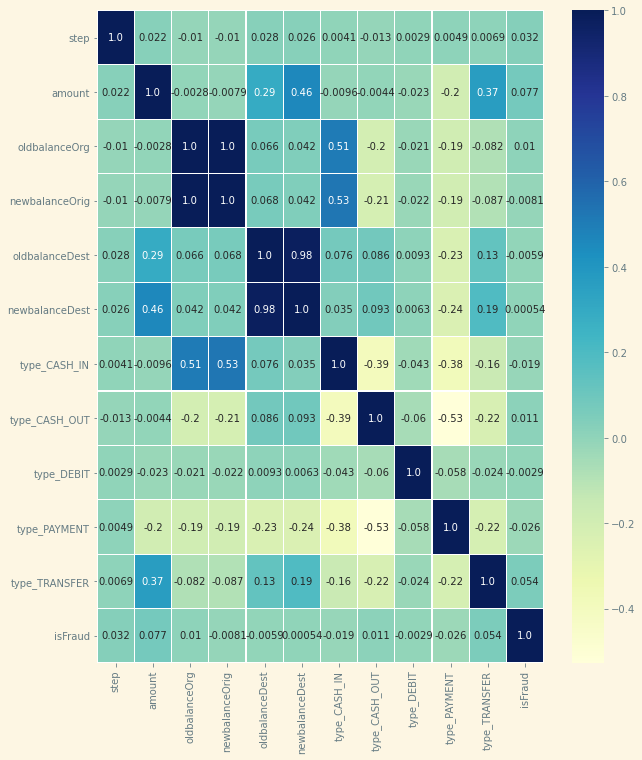

In [10]:
corr= dummies.corr()
f, ax= plt.subplots(figsize= (10,12))

j= sns.heatmap(corr, annot= True, linewidths=.1,
           fmt='.2',cmap= 'YlGnBu', ax=ax)

#Save fig
os.chdir(config['paths']['home'])
from src.visualization.visualize import save_plot

save_plot(plot= j, path= config['paths']['figures'], filename='HeatMap.png')

Successfully saved image to path


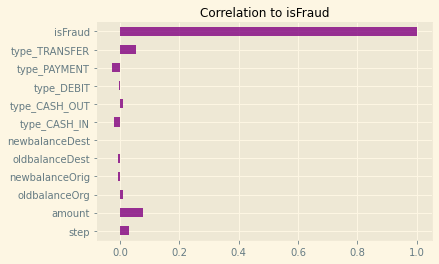

In [18]:
j= dummies.corr()['isFraud'].plot(kind= 'barh', color= 'purple', alpha= .8)
j.set_title('Correlation to isFraud', fontsize= 12);

save_plot(plot= j, path= config['paths']['figures'], filename='correlation.png')

Occurence of Fraud by Transaction Type

In [ ]:
sns.countplot(x= df['type'], hue= df['isFraud'])

**Evaluating Predictions from Previous Model**

Looking at metrics, previous model was optimized for accuracy/precision. Previous prediction model performed very poorly at identifying which transactions are fraudulent. For our task, a False positive won't kill us (we can always verfiy the transaction later) but a False negative can ruin us.

We'll optimize our new models for Recall and F2.0 score (but we'll keep an eye on precision as well).

In [ ]:
#Import Evaluation class
config['paths']['pyScripts']
os.chdir(config['paths']['pyScripts'])
from models.metrics import Evaluation

#Convert dtypes from string to int to fit in model evaluation
for col in ['isFraud','isFlaggedFraud']:
    df[col]= [int(x) for x in df[col]]

#Init Evaluation using predictions from previous model
prevModel= Evaluation(predictions=df['isFlaggedFraud'].values,
                      actual= df['isFraud'].values)

print(prevModel.classification_metrics(beta= 2.0))
print(prevModel.confusion_matrix())